In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

In [2]:
class HyperChaoticSystem:
    def __init__(self, a=35.0, b=3.0, c=12.0, d=7.0, dt=0.001):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.dt = dt

    def _hyper_chaotic_map(self, x: float, y: float, z: float, w: float) -> tuple:
        """4D Hyper-Chaotic Chen System"""
        x_next = x + self.dt * (self.a * (y - x) + w)
        y_next = y + self.dt * ((self.c - self.a) * x - x*z + self.c*y)
        z_next = z + self.dt * (x*y - self.b*z)
        w_next = w + self.dt * (-self.d * x)
        return x_next % 1, y_next % 1, z_next % 1, w_next % 1

    def generate_chaotic_sequence(self, x0: float, y0: float, z0: float, w0: float, n_iter: int) -> tuple:
        x_sequence = []
        y_sequence = []
        z_sequence = []
        w_sequence = []
        x, y, z, w = x0, y0, z0, w0
        
        for _ in range(n_iter):
            x, y, z, w = self._hyper_chaotic_map(x, y, z, w)
            x_sequence.append(x)
            y_sequence.append(y)
            z_sequence.append(z)
            w_sequence.append(w)
            
        return x_sequence, y_sequence, z_sequence, w_sequence

    def lyapunov_exponent(self, x0: float, y0: float, z0: float, w0: float, n_iter: int) -> tuple:
        """Calculate Lyapunov exponents for all 4 dimensions"""
        # Initialize variables
        x, y, z, w = x0, y0, z0, w0
        J = np.eye(4)  # Jacobian matrix
        LE = np.zeros(4)
        
        for _ in range(n_iter):
            # Calculate Jacobian
            J11 = 1 + self.dt*(-self.a)
            J12 = self.dt*self.a
            J13 = 0
            J14 = self.dt
            
            J21 = self.dt*(self.c - self.a - z)
            J22 = 1 + self.dt*self.c
            J23 = -self.dt*x
            J24 = 0
            
            J31 = self.dt*y
            J32 = self.dt*x
            J33 = 1 - self.dt*self.b
            J34 = 0
            
            J41 = -self.dt*self.d
            J42 = 0
            J43 = 0
            J44 = 1
            
            J_current = np.array([[J11, J12, J13, J14],
                                 [J21, J22, J23, J24],
                                 [J31, J32, J33, J34],
                                 [J41, J42, J43, J44]])
            
            # QR decomposition
            Q, R = np.linalg.qr(J_current @ J)
            J = Q  # Update Jacobian
            
            # Accumulate Lyapunov exponents
            LE += np.log(np.abs(np.diag(R)))
            
            # Update state
            x, y, z, w = self._hyper_chaotic_map(x, y, z, w)
        
        return LE / (n_iter * self.dt)

    def sensitivity_analysis(self, x0: float, y0: float, z0: float, w0: float, 
                            delta=1e-10, n_iter=1000) -> tuple:
        """Analyze sensitivity to initial conditions"""
        # Generate reference trajectory
        x_ref, y_ref, z_ref, w_ref = self.generate_chaotic_sequence(x0, y0, z0, w0, n_iter)
        
        # Generate perturbed trajectory
        x_pert, y_pert, z_pert, w_pert = self.generate_chaotic_sequence(
            x0 + delta, y0 + delta, z0 + delta, w0 + delta, n_iter)
        
        # Calculate divergence
        divergence = []
        for i in range(n_iter):
            dist = np.sqrt((x_ref[i]-x_pert[i])**2 + (y_ref[i]-y_pert[i])**2 + 
                          (z_ref[i]-z_pert[i])**2 + (w_ref[i]-w_pert[i])**2)
            divergence.append(dist)
            
        return x_ref, y_ref, z_ref, w_ref, x_pert, y_pert, z_pert, w_pert, divergence

    def plot_time_series(self, x_sequence, y_sequence, z_sequence, w_sequence):
        """Plot time series of all variables"""
        plt.figure(figsize=(12, 8))
        plt.plot(x_sequence, label='x')
        plt.plot(y_sequence, label='y')
        plt.plot(z_sequence, label='z')
        plt.plot(w_sequence, label='w')
        plt.title('Hyper-Chaotic System Time Series')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_3d_phase_space(self, x_sequence, y_sequence, z_sequence):
        """Plot 3D phase space"""
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x_sequence, y_sequence, z_sequence, lw=0.5)
        ax.set_title('3D Phase Space (x-y-z)')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    def plot_lyapunov_exponents(self, x0, y0, z0, w0, n_iter=10000):
        """Calculate and plot Lyapunov exponents over time"""
        LE = self.lyapunov_exponent(x0, y0, z0, w0, n_iter)
        plt.figure(figsize=(10, 6))
        plt.bar(['λ1', 'λ2', 'λ3', 'λ4'], LE)
        plt.title('Lyapunov Exponents')
        plt.ylabel('Exponent Value')
        plt.grid(True)
        plt.show()
        return LE

    def plot_sensitivity(self, x0, y0, z0, w0, delta=1e-10, n_iter=1000):
        """Plot sensitivity to initial conditions"""
        _, _, _, _, _, _, _, _, divergence = self.sensitivity_analysis(
            x0, y0, z0, w0, delta, n_iter)
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(divergence)
        plt.title('Sensitivity to Initial Conditions (Log Scale)')
        plt.xlabel('Iteration')
        plt.ylabel('Divergence (log scale)')
        plt.grid(True)
        plt.show()

    def plot_cobweb(self, x0, y0, z0, w0, n_iter=1000, dim1='x', dim2='y'):
        """Plot cobweb diagram between two selected dimensions"""
        x_seq, y_seq, z_seq, w_seq = self.generate_chaotic_sequence(
            x0, y0, z0, w0, n_iter)
        
        # Select dimensions to plot
        dim_map = {'x': x_seq, 'y': y_seq, 'z': z_seq, 'w': w_seq}
        dim1_seq = dim_map[dim1]
        dim2_seq = dim_map[dim2]
        
        # Create cobweb plot
        plt.figure(figsize=(8, 8))
        plt.plot(dim1_seq, dim2_seq, 'b-', lw=0.5)
        plt.title(f'Cobweb Plot ({dim1}-{dim2} plane)')
        plt.xlabel(dim1)
        plt.ylabel(dim2)
        plt.grid(True)
        plt.show()

In [3]:
# Initialize system with default parameters
hyper_system = HyperChaoticSystem()
    
# Generate chaotic sequences
x_seq, y_seq, z_seq, w_seq = hyper_system.generate_chaotic_sequence(
    x0=0.1, y0=0.2, z0=0.3, w0=0.4, n_iter=10000)

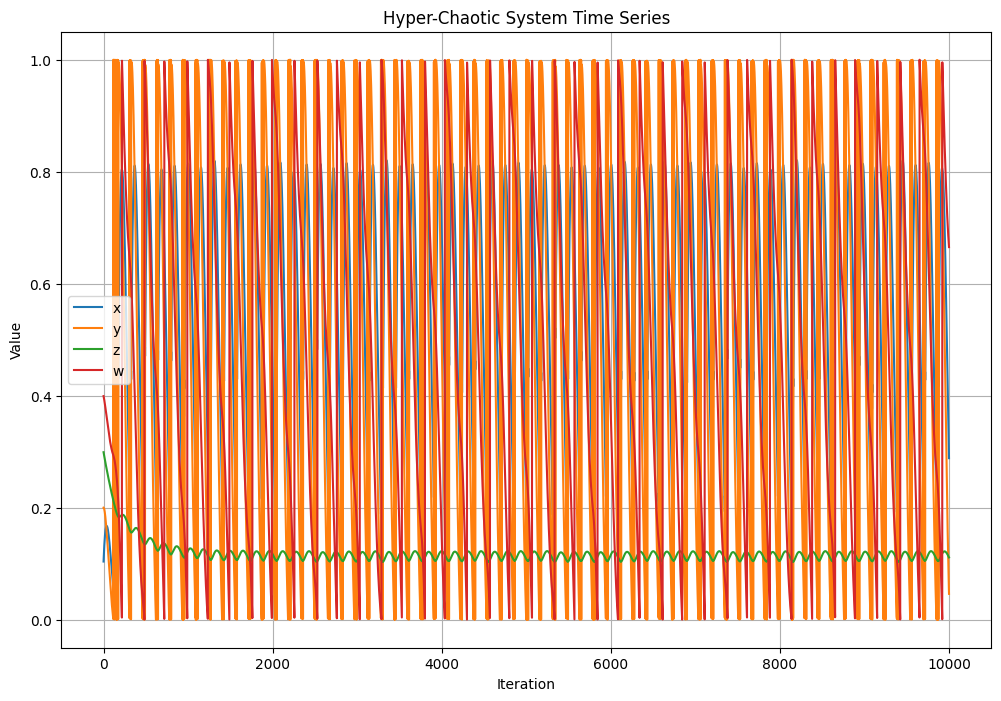

In [4]:
# Plot time series
hyper_system.plot_time_series(x_seq, y_seq, z_seq, w_seq)

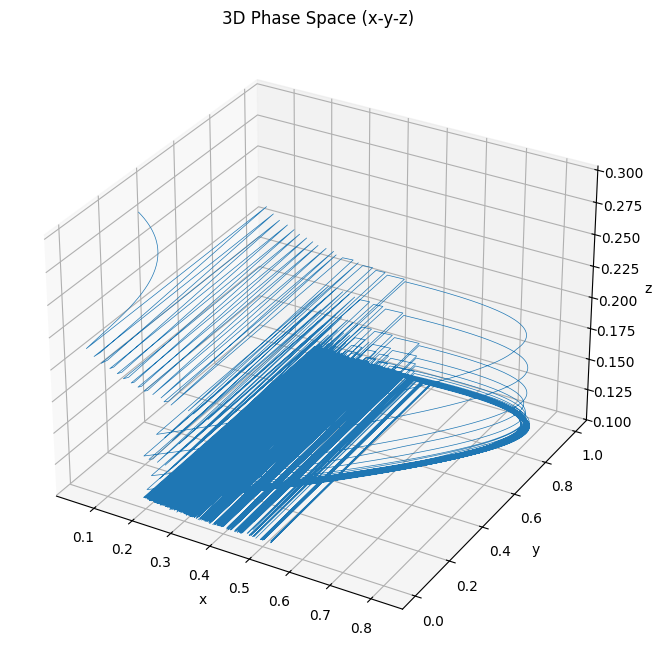

In [5]:
# Plot 3D phase space
hyper_system.plot_3d_phase_space(x_seq, y_seq, z_seq)

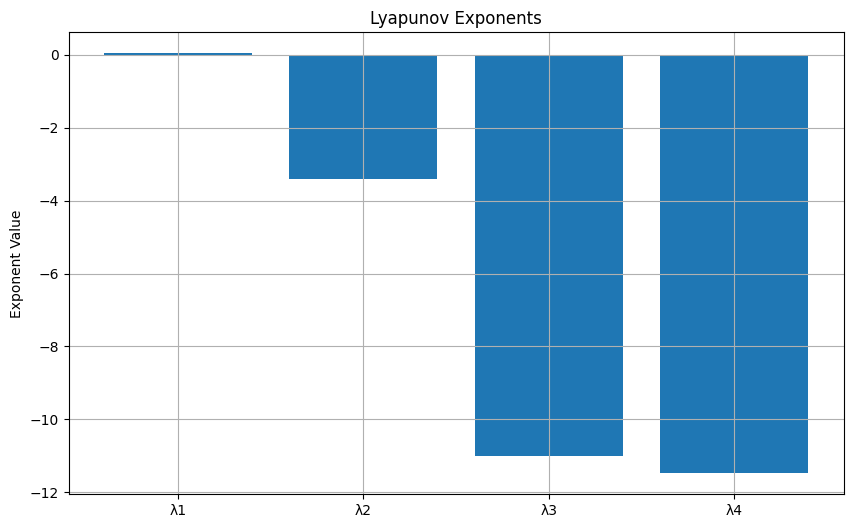

Lyapunov Exponents: [  0.04444496  -3.41352534 -11.01836838 -11.4798704 ]


In [6]:
# Calculate and plot Lyapunov exponents
LE = hyper_system.plot_lyapunov_exponents(0.1, 0.2, 0.3, 0.4)
print("Lyapunov Exponents:", LE)

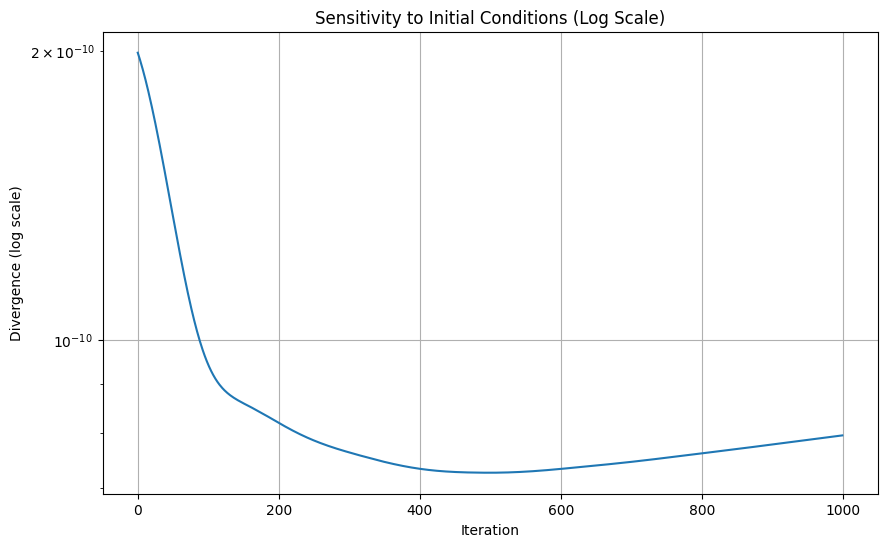

In [7]:
# Plot sensitivity to initial conditions
hyper_system.plot_sensitivity(0.1, 0.2, 0.3, 0.4)

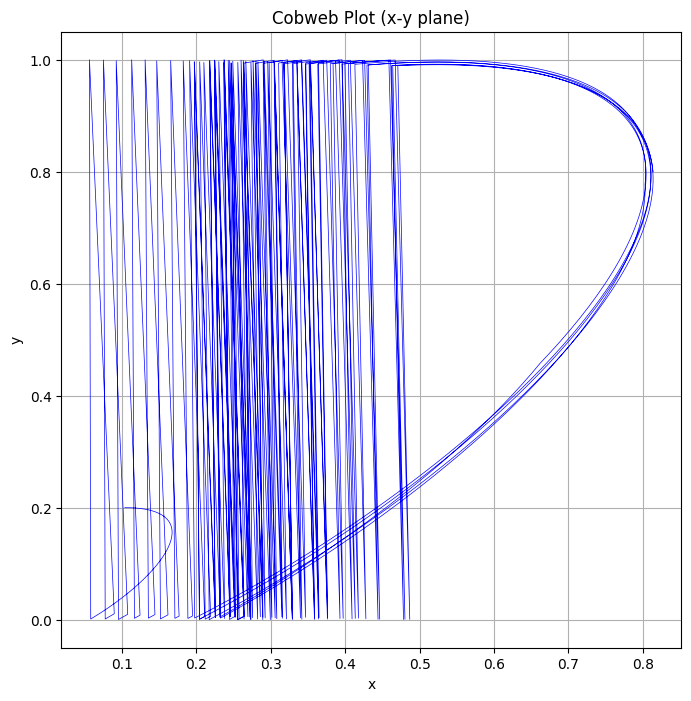

In [9]:
# Plot cobweb diagrams for different dimension pairs
hyper_system.plot_cobweb(0.1, 0.2, 0.3, 0.4, dim1='x', dim2='y')

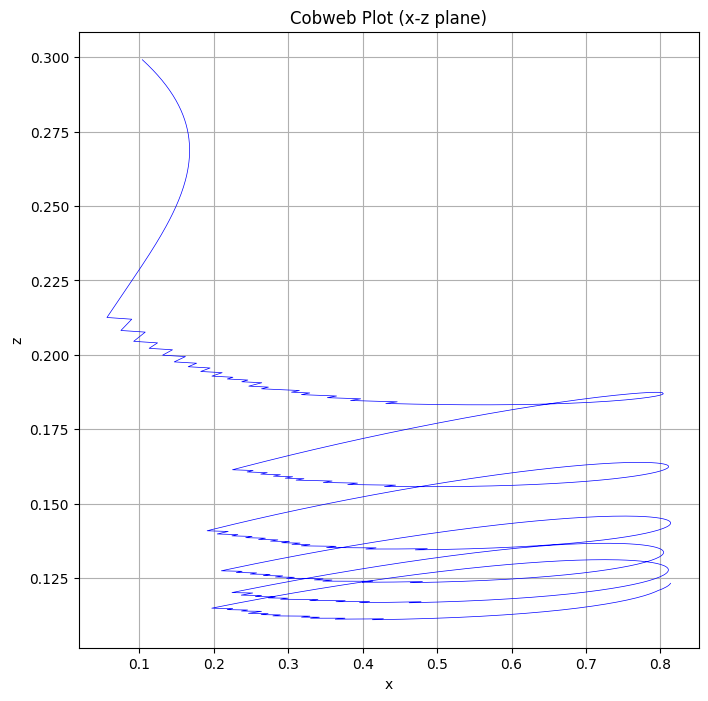

In [10]:
hyper_system.plot_cobweb(0.1, 0.2, 0.3, 0.4, dim1='x', dim2='z')

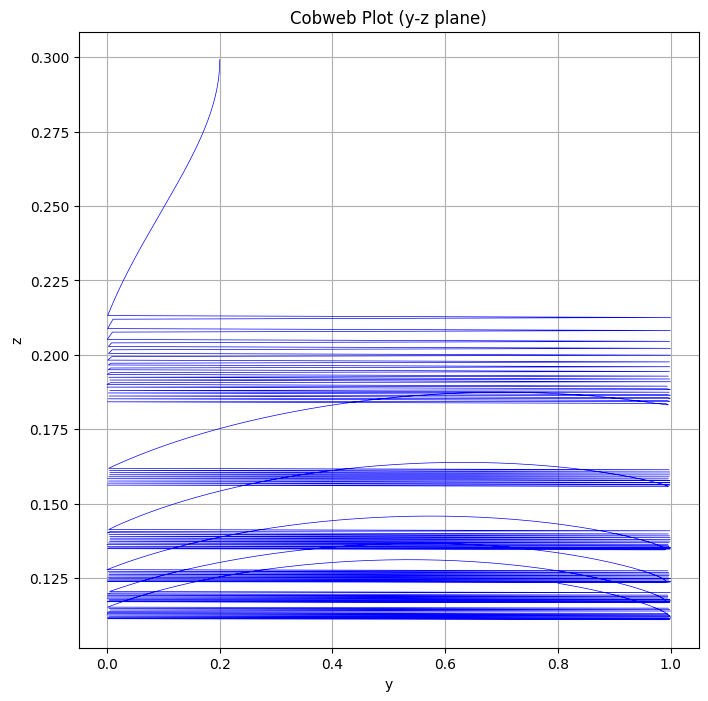

In [11]:
hyper_system.plot_cobweb(0.1, 0.2, 0.3, 0.4, dim1='y', dim2='z')